In [37]:
import pickle
import numpy as np
import pandas as pd

import torch
import json
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay

from embedding import BertHuggingface
from geometrical_bias import SAME, WEAT, GeneralizedWEAT, DirectBias, MAC, normalize, cossim, EmbSetList, EmbSet, GeometricBias
from utils import CLFHead, SimpleCLFHead, CustomModel, JigsawDataset, BiosDataset, DebiasPipeline


## Evaluation
- check if debias reduces extrinsic biases
- plot correlation (job-wise vs. overall)
- cosine scores on train or eval data?

In [77]:
with open('results/bios_15028/config.json', 'r') as f:
    exp_config = json.load(f)

save_file = exp_config['save_dir']+'res.pickle' #results/bios1/res.pickle' #res_bios.pickle
with open(save_file, 'rb') as handle:
    res = pickle.load(handle)
    exp_parameters = res['params']
    results = res['results']
    #results_test = res['results_eval']
    

cosine_scores = {'SAME': SAME, 'WEAT': WEAT, 'gWEAT': GeneralizedWEAT, 'DirectBias': DirectBias, 'MAC': MAC}

In [78]:
exp_config

{'bias_types': ['gender'],
 'bias_scores': ['SAME', 'WEAT', 'gWEAT', 'DirectBias', 'MAC'],
 'embedders': ['bert-base-uncased',
  'word2vec-google-news-300',
  'fasttext-wiki-news-subwords-300',
  'glove-wiki-gigaword-300',
  'glove-twitter-200',
  'bert-large-uncased',
  'distilbert-base-uncased',
  'roberta-base',
  'roberta-large',
  'distilroberta-base',
  'xlm-roberta-base',
  'albert-base-v2',
  'albert-large-v2',
  'google/electra-base-generator',
  'google/electra-large-generator',
  'bert-base-multilingual-uncased',
  'GroNLP/hateBERT',
  'Twitter/twhin-bert-base',
  'medicalai/ClinicalBERT',
  'albert-xlarge-v2',
  'bert-large-uncased-whole-word-masking',
  'abhi1nandy2/Bible-roberta-base',
  'distilbert-base-uncased-finetuned-sst-2-english',
  'gpt2',
  'openai-gpt',
  'xlnet-base-cased'],
 'clf_heads': ['SimpleCLFHead'],
 'debias': True,
 'debias_k': [1, 3, 5],
 'clf_optimizer': ['RMSprop'],
 'clf_criterion': ['BCEWithLogitsLoss'],
 'lr': [0.005, 0.001, 0.0005, 0.0001, 5e-05

In [79]:
assert len(exp_parameters) == len(results), "shape mismatch: "+str(len(exp_parameters))+" vs. "+str(len(results))

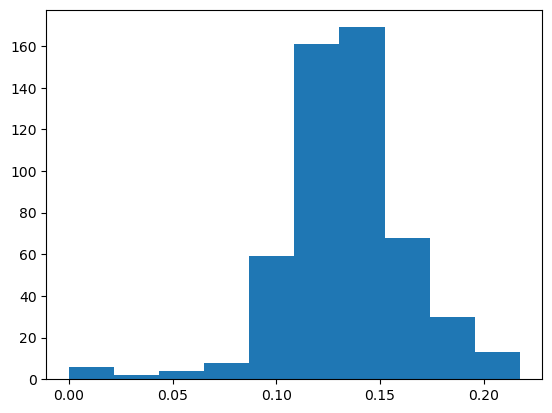

In [80]:
recalls = [res['extrinsic'] for res in results]
counts, bins = np.histogram(recalls)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

# compare only models with "extreme" gap differences (to remove random effects)

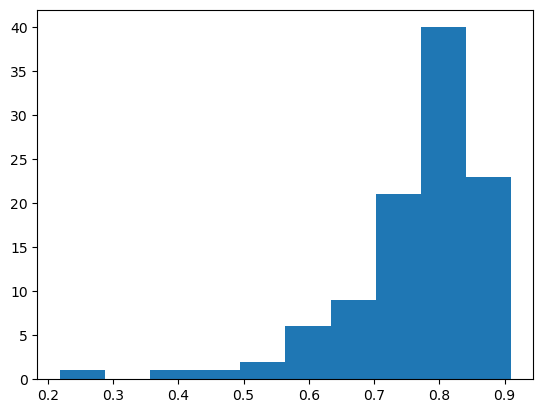

In [81]:
recalls = [res['recall'] for res in results]
counts, bins = np.histogram(recalls)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [82]:
blacklist_models = []

cur_model = ""
for i, res in enumerate(results):
    if exp_parameters[i]['embedder'] != cur_model:
        cur_model = exp_parameters[i]['embedder']
        print()
        print(cur_model)
    if res['recall'] > 0.5 and min(res['class_recall']) > 0.1:
        continue
    
    if not cur_model in blacklist_models:
        blacklist_models.append(cur_model)
    if exp_parameters[i]['debias']:
        print(exp_parameters[i]['lr'], exp_parameters[i]['debias'], exp_parameters[i]['debias_k'])
    else:
        print(exp_parameters[i]['lr'], exp_parameters[i]['debias'])
    #print(res['recall'])
    #print(res['class_recall'])
    
blacklist_models


bert-base-uncased

word2vec-google-news-300

fasttext-wiki-news-subwords-300

glove-wiki-gigaword-300

glove-twitter-200

bert-large-uncased

distilbert-base-uncased

roberta-base

roberta-large

distilroberta-base

xlm-roberta-base

albert-base-v2

albert-large-v2

google/electra-base-generator

google/electra-large-generator

bert-base-multilingual-uncased

GroNLP/hateBERT

Twitter/twhin-bert-base

medicalai/ClinicalBERT

albert-xlarge-v2
[0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06] False

bert-large-uncased-whole-word-masking

abhi1nandy2/Bible-roberta-base

distilbert-base-uncased-finetuned-sst-2-english

gpt2
[0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06] False
[0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06] True 5

openai-gpt

xlnet-base-cased
[0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06] False


['albert-xlarge-v2', 'gpt2', 'xlnet-base-cased']

In [83]:
results[i].keys()

dict_keys(['id', 'extrinsic', 'extrinsic_individual', 'extrinsic_classwise', 'subgroup_AUC', 'BPSN', 'BNSP', 'extrinsic_classwise_neutral', 'subgroup_AUC_neutral', 'BPSN_neutral', 'BNSP_neutral', 'SAME', 'SAME_cf', 'SAME_neutral', 'SAME_individual', 'SAME_classwise', 'SAME_classwise_neutral', 'WEAT', 'WEAT_cf', 'WEAT_neutral', 'WEAT_individual', 'WEAT_classwise', 'WEAT_classwise_neutral', 'gWEAT', 'gWEAT_cf', 'gWEAT_neutral', 'gWEAT_individual', 'gWEAT_classwise', 'gWEAT_classwise_neutral', 'DirectBias', 'DirectBias_cf', 'DirectBias_neutral', 'DirectBias_individual', 'DirectBias_classwise', 'DirectBias_classwise_neutral', 'MAC', 'MAC_cf', 'MAC_neutral', 'MAC_individual', 'MAC_classwise', 'MAC_classwise_neutral', 'recall', 'precision', 'f1', 'class_recall'])

In [84]:
score_list = list(cosine_scores.keys())+['extrinsic']
score_list.remove('gWEAT')
scores_per_bias_type = {bt : {score: [] for score in score_list+['subgroup_AUC', 'BNSP', 'BPSN']} for bt in exp_config['bias_types']}
#class_wise_scores = {score: [] for score in score_list}

counts = {score: 0 for score in score_list}
corr_per_score = {score: {'r': [], 'p': []} for score in score_list}
for i in range(len(results)):
    print("experiment", i, "with bias type", exp_parameters[i]['bias_type'], "and", exp_parameters[i]['embedder'])
    
    if exp_parameters[i]['embedder'] in blacklist_models+['glove-wiki-gigaword-300']:
        print("skip blastlisted models")
        continue
    
    for score in score_list:
        if score == 'SAME':
            scores_per_bias_type[exp_parameters[i]['bias_type']][score].append(np.mean(np.var(results[i][score+"_classwise_neutral"], axis=1)))
        else:
            scores_per_bias_type[exp_parameters[i]['bias_type']][score].append(np.mean(results[i][score]))
    for score in ['subgroup_AUC', 'BNSP', 'BPSN']:
        scores_per_bias_type[exp_parameters[i]['bias_type']][score].append(np.mean(np.mean(np.abs(results[i][score]), axis=1)))
    
    for score in score_list:#+['BPSN']:
        if score == 'gWEAT':
            continue
        for score2 in score_list:
            if score == score2 or score2 == 'gWEAT':
                continue
                
            # class-wise bias scores
            if score == 'BPSN':
                scores1 = np.mean(results[i][score], axis=0)
            else:
                scores1 = np.mean(results[i][score+'_classwise_neutral'], axis=0)
            if score2 == 'DirectBias' or score2 == 'MAC':
                scores1 = np.abs(scores1)
            scores2 = np.mean(results[i][score2+'_classwise_neutral'], axis=0)
            
            #scores1 = list(itertools.chain.from_iterable(results[i][score+'_individual']))
            #scores2 = list(itertools.chain.from_iterable(results[i][score2+'_individual']))
            
            #class_wise_scores[score].append(scores1)
            try:
                slope, intercept, r, p, std_err = scipy.stats.linregress(scores1, scores2)
            except ValueError:
                print("invalid values for ", score, score2)
                print(results[i]['recall'])
            if 'extrinsic' in score:
                corr_per_score[score2]['r'].append(r)
                corr_per_score[score2]['p'].append(p)
                
            if 'extrinsic' in score and p < 0.01 and np.abs(r) > 0.7:
                print(score, score2, "R="+str(r)+" (p="+str(p)+")")
                counts[score2] += 1
                #res = {score: scores1, score2: scores2}
                #df = pd.DataFrame(res)
                #sns.regplot(x=score, y=score2, data=df).set_title("R="+str(r)+" (p="+str(p)+")")
                #plt.show()
    print()
    print()

experiment 0 with bias type gender and bert-base-uncased


experiment 1 with bias type gender and bert-base-uncased
extrinsic SAME R=0.7295205325024965 (p=0.0030644170656920007)
extrinsic WEAT R=0.7295204670433287 (p=0.0030644210354505777)


experiment 2 with bias type gender and bert-base-uncased


experiment 3 with bias type gender and bert-base-uncased


experiment 4 with bias type gender and word2vec-google-news-300


experiment 5 with bias type gender and word2vec-google-news-300
extrinsic SAME R=0.7155991305171858 (p=0.0040051407623180905)
extrinsic WEAT R=0.7155991435870052 (p=0.004005139783963025)


experiment 6 with bias type gender and word2vec-google-news-300
extrinsic SAME R=0.713667737561434 (p=0.004151778562440883)
extrinsic WEAT R=0.7136677143707115 (p=0.004151780348073661)


experiment 7 with bias type gender and word2vec-google-news-300
extrinsic SAME R=0.721152349283656 (p=0.0036060553372251176)
extrinsic WEAT R=0.7211523627386563 (p=0.003606054409736776)


experiment

In [85]:
counts

{'SAME': 18, 'WEAT': 18, 'DirectBias': 0, 'MAC': 0, 'extrinsic': 0}

In [86]:
mean_corr_per_score = {score: {'r': np.mean(corr_per_score[score]['r']), 'p': np.mean(corr_per_score[score]['p']), 'err': np.std(corr_per_score[score]['r'])} for score in ['SAME', 'WEAT', 'DirectBias', 'MAC']}
mean_corr_per_score

{'SAME': {'r': 0.4232892394403755,
  'p': 0.15544905794603883,
  'err': 0.3549657374429923},
 'WEAT': {'r': 0.42328938407113126,
  'p': 0.15544875379589201,
  'err': 0.35496617380582024},
 'DirectBias': {'r': -0.042581063651121,
  'p': 0.5205455777458052,
  'err': 0.25679175765366047},
 'MAC': {'r': 0.06895008362625274,
  'p': 0.6162465515622819,
  'err': 0.18720600913308094}}

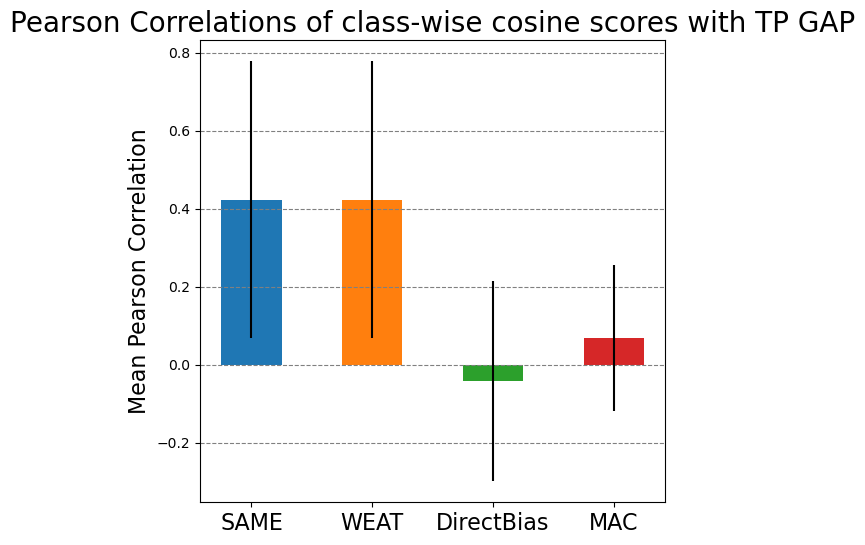

In [87]:
eval_scores = ['SAME', 'WEAT', 'DirectBias', 'MAC']
width = 0.5
#offset = np.asarray([-3*width/2, -width/2, width/2, 3*width/2])
x = np.arange(len(eval_scores))

fig, ax = plt.subplots(figsize=(6,6))
    
for i, score in enumerate(eval_scores):
    r_mean = mean_corr_per_score[score]['r']
    r_std = mean_corr_per_score[score]['err']
    p_mean = mean_corr_per_score[score]['p']
    
    ax.bar(x[i], r_mean, width, yerr=r_std)#, label=score)
    
ax.set_ylabel('Mean Pearson Correlation', fontsize=16)
ax.set_xticks(x, eval_scores, fontsize=16)
#ax.set_ylim(-0.19,1.1)
ax.grid(color='grey', linestyle='--', axis='y')
ax.set_title('Pearson Correlations of class-wise cosine scores with TP GAP', fontsize=20)
#ax.legend(loc='upper right', bbox_to_anchor=(0.85, 0.5, 0., 0.5), fontsize=16)
#plt.savefig('plots/word_bias_corr.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


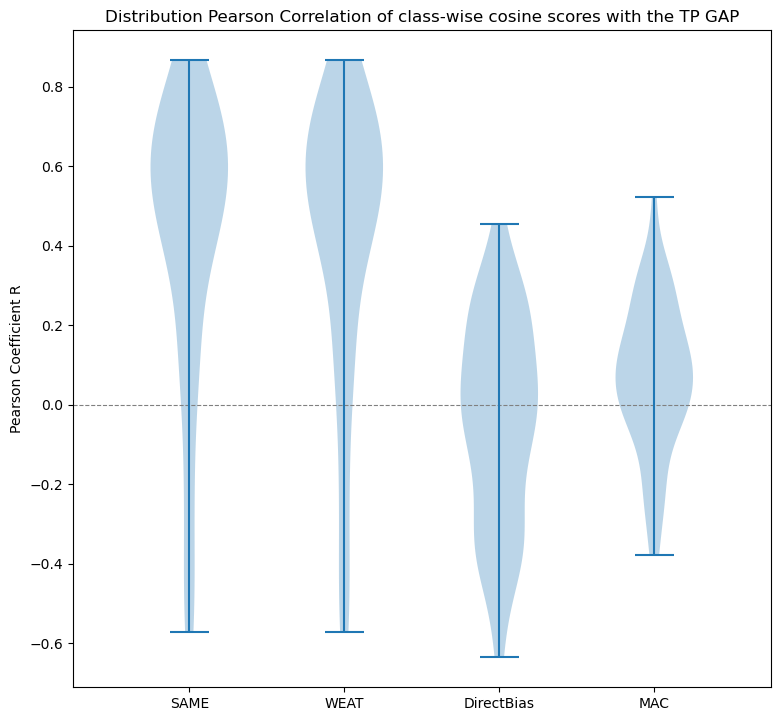

In [88]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    #ax.set_xlabel('Sample name')
    ax.hlines(0,0.25, len(labels) + 0.75, 'grey', '--', linewidths=0.8)

data = [corr_per_score[score]['r'] for score in eval_scores]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9), sharey=True)

# set style for the axes
labels = eval_scores
set_axis_style(ax, labels)

ax.set_title('Distribution Pearson Correlation of class-wise cosine scores with the TP GAP')
ax.set_ylabel('Pearson Coefficient R')
ax.violinplot(data)

plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.savefig('plots/bios_class_bias.eps', format='eps')
plt.show()

gender
SAME


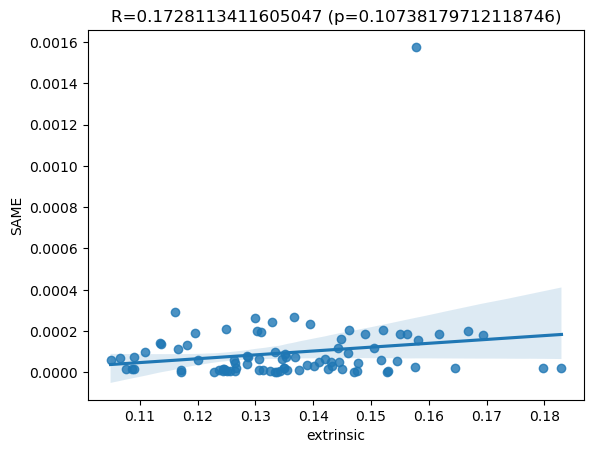


WEAT


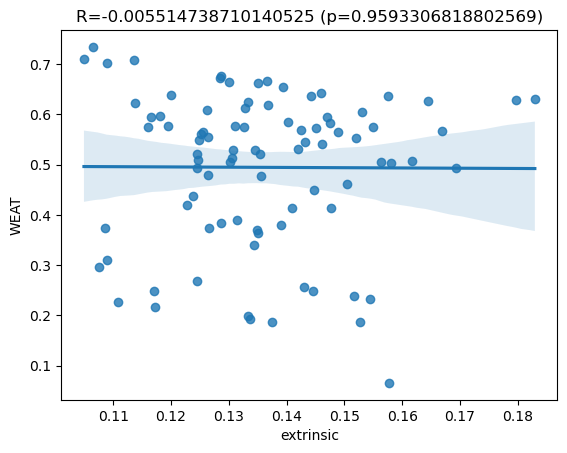


DirectBias


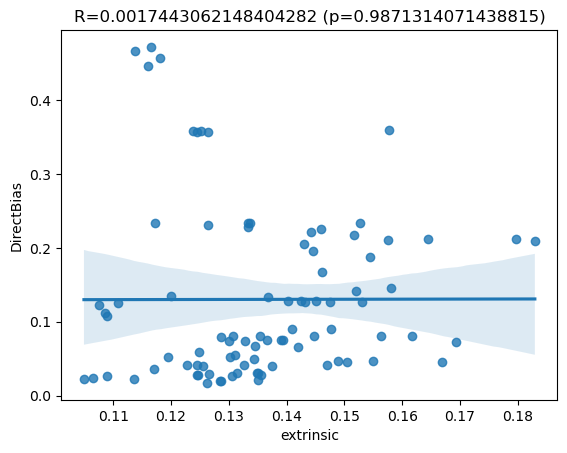


MAC


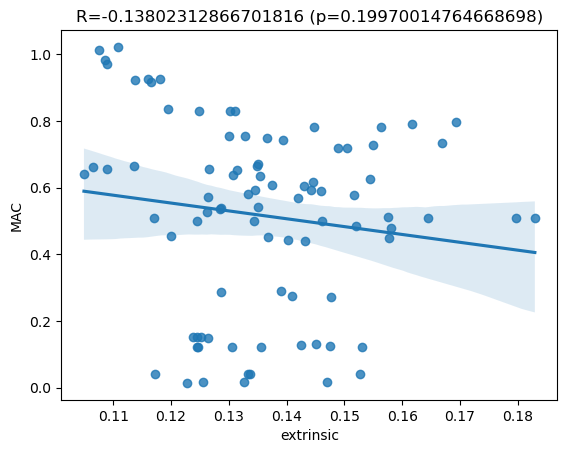


gender
SAME


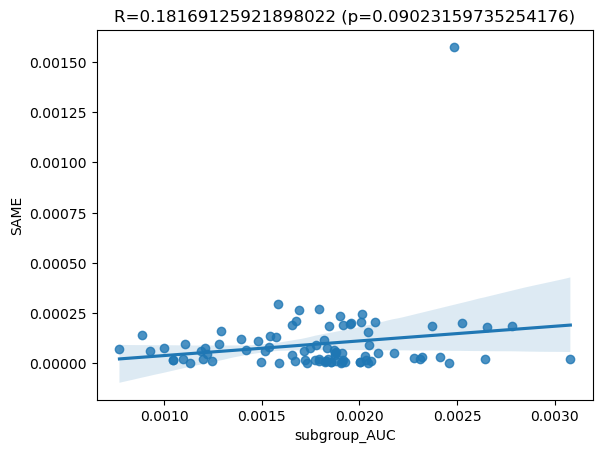


WEAT


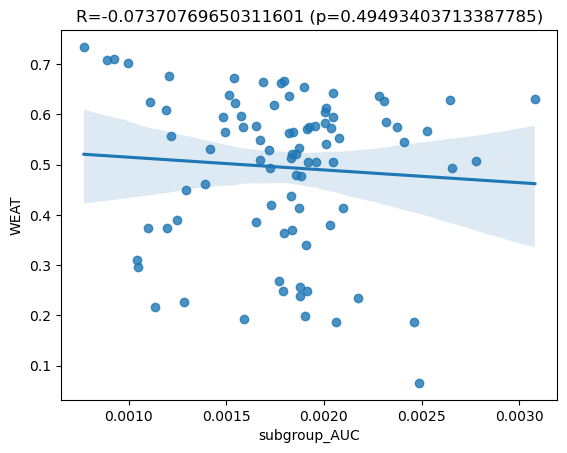


DirectBias


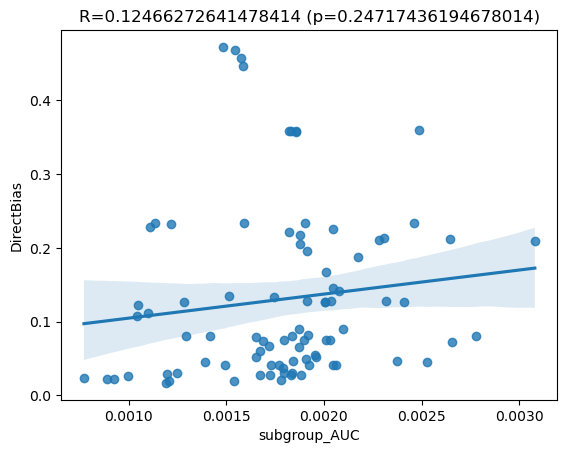


MAC


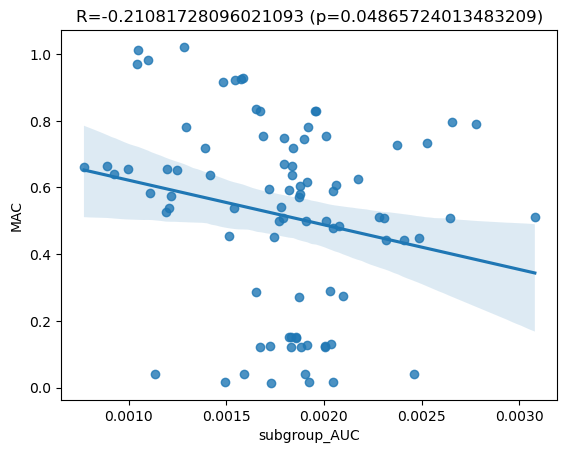


gender
SAME


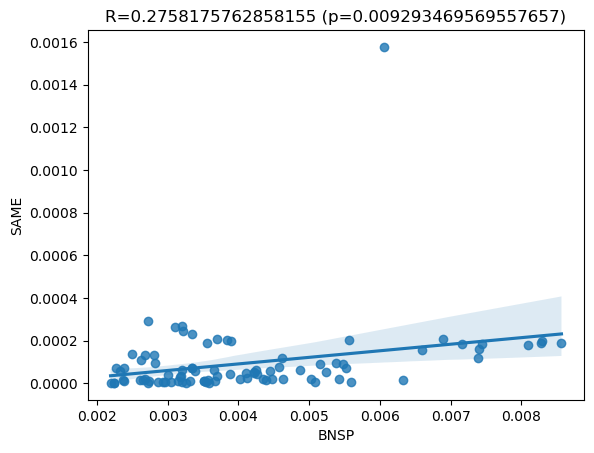


WEAT


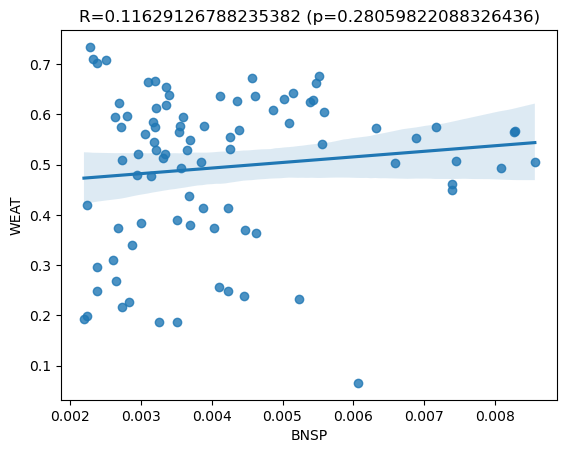


DirectBias


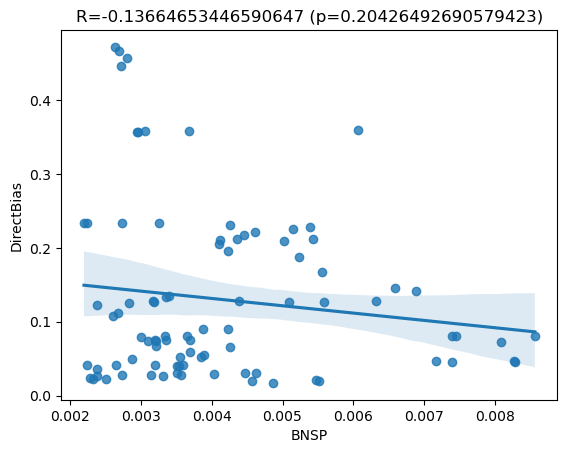


MAC


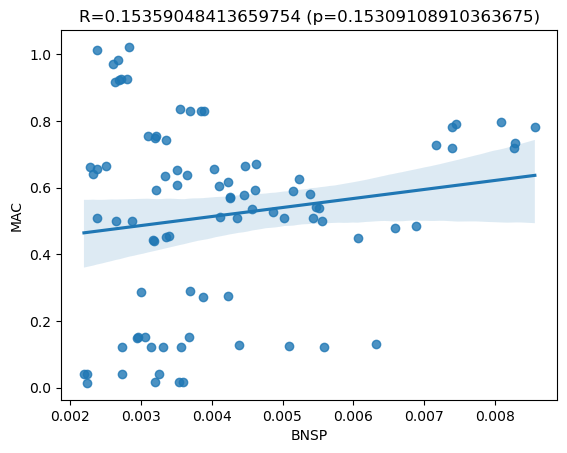


gender
SAME


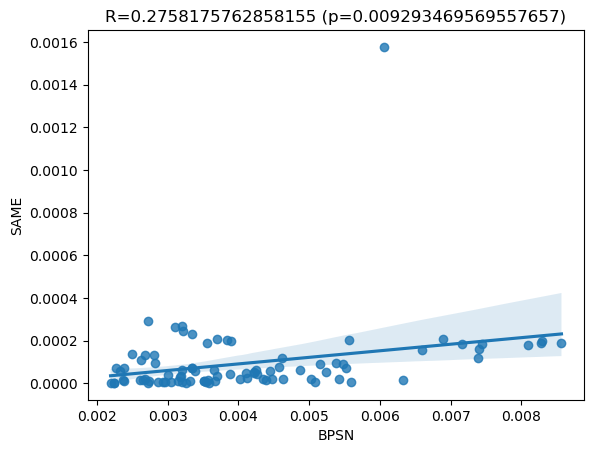


WEAT


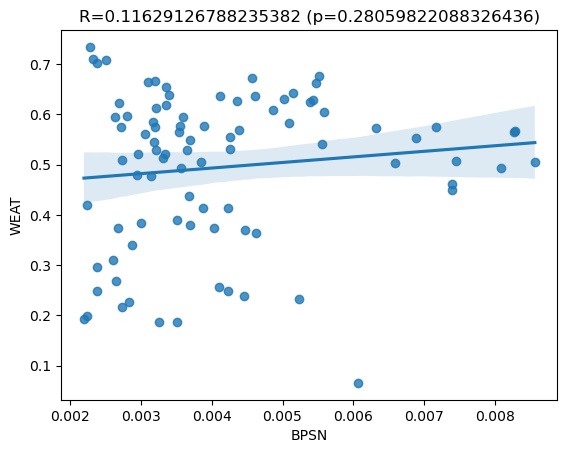


DirectBias


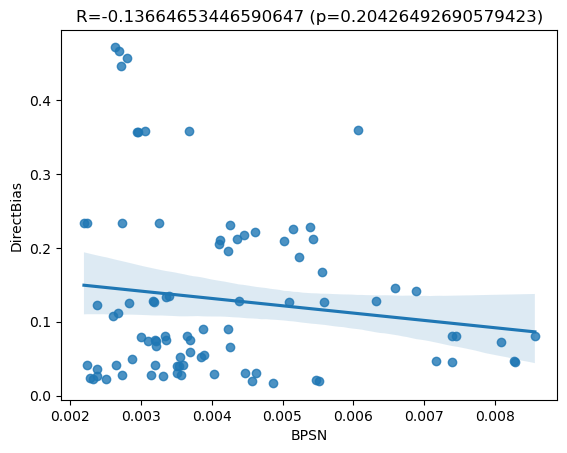


MAC


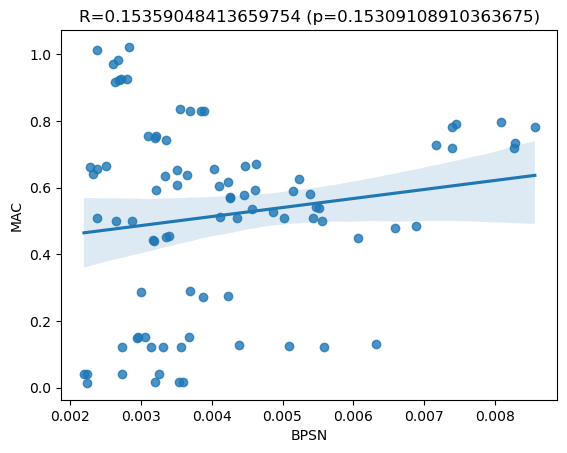

In [89]:
mean_scores = {}
for bt, res in scores_per_bias_type.items():
    mean_scores[bt] = {score: 0}
    for score in score_list+['subgroup_AUC', 'BNSP', 'BPSN']:
        mean_scores[bt][score] = np.abs(scores_per_bias_type[bt][score])
        
for comp in ['extrinsic', 'subgroup_AUC', 'BNSP', 'BPSN']:
    for bt, res in mean_scores.items():
        df = pd.DataFrame(res)
        print(bt)
        for score in score_list:
            if not score == 'extrinsic':
                print(score)
                slope, intercept, r, p, std_err = scipy.stats.linregress(df.loc[:,comp], df.loc[:,score])
                #print(r, p)
                sns.regplot(x=comp, y=score, data=df).set_title("R="+str(r)+" (p="+str(p)+")")
                plt.show()
                
                print()

In [90]:
#exp_parameters[110]

In [91]:
debias_ks = exp_config['debias_k']
embedder = exp_config['embedders']

In [92]:
debias_ks

[1, 3, 5]

## Do cosine scores predict debiasing success?

### a) Individual bias scores
As shown in the paper, WEATs individual bias score is not magnitude comparable, which leads to arbitrary/incomparable score magnitudes. Hence it cannot show if a model is more/less biased in sense of the bias definition. MAC has the same problem. DirectBias and SAME are magnitude comparable, but as shown above the DirectBias performs poor overall. So we expect only SAME to decently predict debiasing success in terms of individual bias scores.


#### Result:
As expected from theory, SAME performs better than WEAT but only by a tiny margin. Overall both barely achieve a ROC AUC over 0.5...


SAME


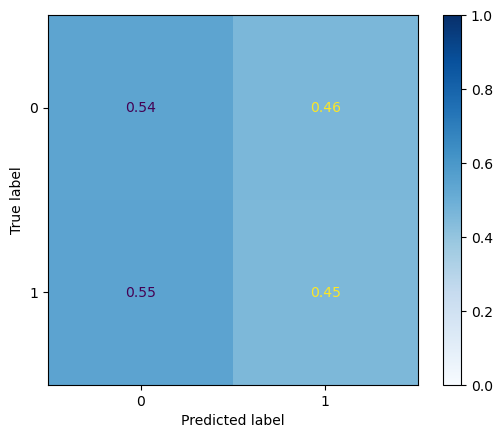

ROC AUC:  0.49762982392639044

WEAT


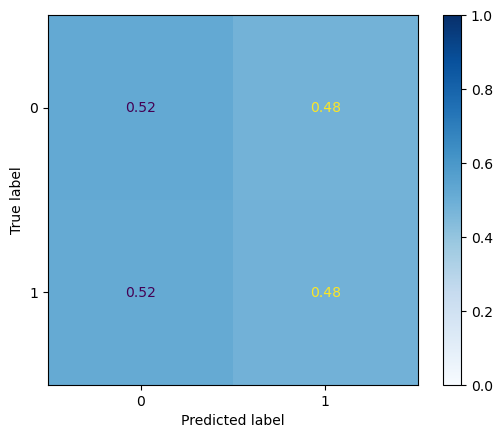

ROC AUC:  0.5020138824128181

DirectBias


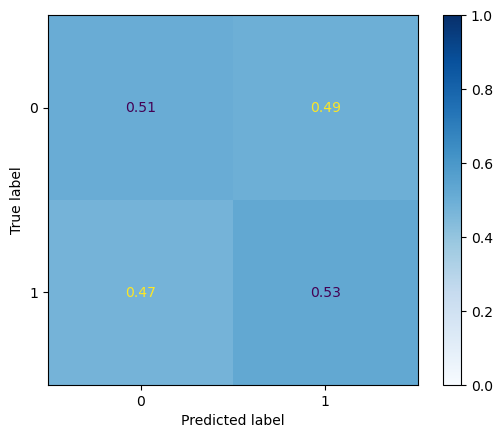

ROC AUC:  0.5153729848004203

MAC


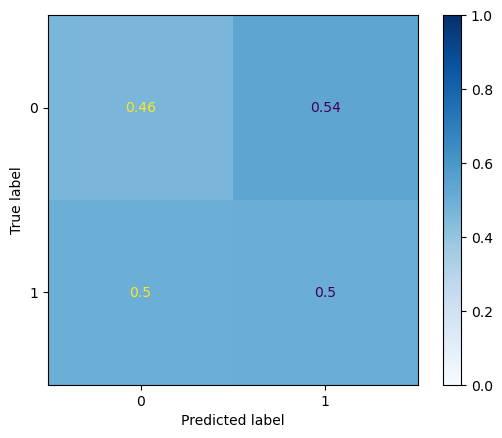

ROC AUC:  0.4825801377545887



In [93]:
all_scores = list(cosine_scores.keys())+['extrinsic']
all_scores.remove('gWEAT')
exp_idx = 0
bias_decreased = {score: [] for score in all_scores}

for model in embedder:  
    if model not in blacklist_models:
        default_idx = exp_idx
        version_ids = [exp_idx+i for i in range(len(debias_ks))]
        other_models = [elem for elem in list(range(len(results))) if not elem == default_idx and elem%len(debias_ks)==0]
        rand_ids = other_models #random.sample(other_models, 15)

        for score in all_scores:
            default_scores = np.abs(results[default_idx][score+'_classwise_neutral'])
            for idx in rand_ids:
                cur_res = np.abs(results[idx][score+'_classwise_neutral'])
                cmp = np.mean(cur_res, axis=0) < np.mean(default_scores, axis=0)
                bias_decreased[score] += [int(elem) for elem in cmp]
    exp_idx += len(debias_ks)+1
    
for score in cosine_scores.keys():
    if score == 'gWEAT':
        continue
    print(score)
    cm = confusion_matrix(bias_decreased['extrinsic'],bias_decreased[score], normalize='true')
    cm_display = ConfusionMatrixDisplay(cm).plot()
    cm_display.ax_.get_images()[0].set_clim(0, 1)
    cm_display.ax_.get_images()[0].set_cmap(plt.cm.Blues)
    plt.show()
    print("ROC AUC: ", roc_auc_score(bias_decreased['extrinsic'],bias_decreased[score]))
    #fpr, tpr, _ = roc_curve(bias_decreased['extrinsic'][k],bias_decreased[score][k])
    #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    print()

### b) Predicting Debias Success with Mean/Group Bias Scores
Both the effect size of WEAT and SAME are magnitude comparable. In that sense both fullfil the most important criterion to predict debiasing success. WEAT is not trustworthy, but these corner cases may not be that relevant in practice. Both performed decently on individual score level, but the effect size shows better correlation with the mean abs GAP score.

#### Result:
While this is the less relevant experiment (based on theoretical analysis), here we see a clear difference between SAME (0.59) and WEAT (0.54). Also both perform better in predicting which model is more/less biased. An explanation for that is that single-class GAP scores are always influenced by other classes representation as the classifier optimizes w.r.t. all classes, while cosine scores assess bias independent of other classes and hence cannot predict their mutual influence. So the overall cosine bias is a better estimate of the overall extrinsic bias than class-wise biases of their extrinsic counterpart. Also as shown in the motivational example the effect size is influenced by in-group variance which does not necessarily influence separability.

SAME


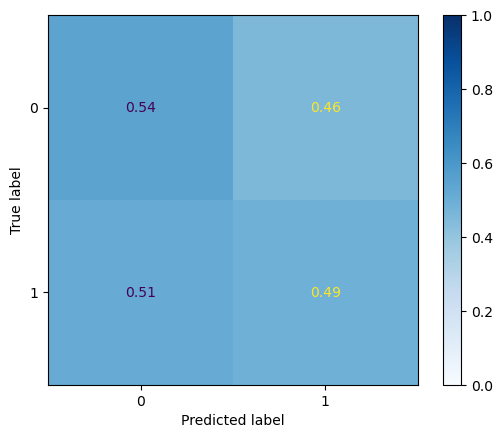

ROC AUC:  0.5162400951874636

WEAT


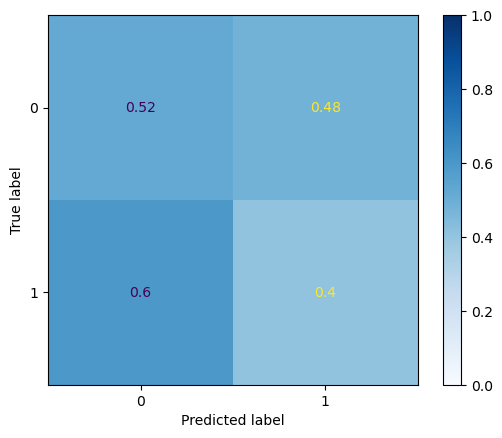

ROC AUC:  0.46314650262018675

DirectBias


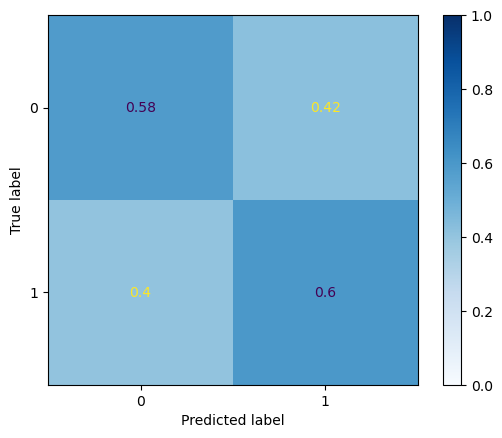

ROC AUC:  0.5882889040783778

MAC


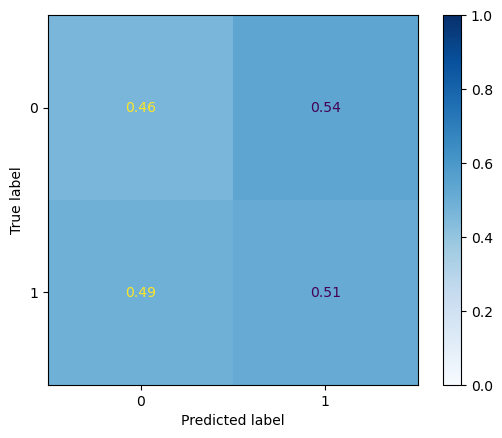

ROC AUC:  0.4860256702361966



In [94]:
all_scores = list(cosine_scores.keys())+['extrinsic']
all_scores.remove('gWEAT')
exp_idx = 0
bias_decreased = {score: [] for score in all_scores}

for model in embedder:
    if not model in blacklist_models:
        default_idx = exp_idx
        version_ids = [exp_idx+i for i in range(len(debias_ks))]
        other_models = [elem for elem in list(range(len(results))) if not elem == default_idx and elem%len(debias_ks)==0]
        rand_ids = other_models #random.sample(other_models, 15)

        for score in all_scores:
            default_scores = np.abs(results[default_idx][score])
            for idx in rand_ids:
                cur_res = np.abs(results[idx][score])
                cmp = np.mean(cur_res, axis=0) < np.mean(default_scores, axis=0)
                bias_decreased[score].append(int(cmp))
    exp_idx += len(debias_ks)+1
    
#print(bias_decreased)
    

for score in cosine_scores.keys():
    if score == 'gWEAT':
        continue
    print(score)
    cm = confusion_matrix(bias_decreased['extrinsic'],bias_decreased[score], normalize='true')
    cm_display = ConfusionMatrixDisplay(cm).plot()
    cm_display.ax_.get_images()[0].set_clim(0, 1)
    cm_display.ax_.get_images()[0].set_cmap(plt.cm.Blues)
    plt.show()
    print("ROC AUC: ", roc_auc_score(bias_decreased['extrinsic'],bias_decreased[score]))
    #fpr, tpr, _ = roc_curve(bias_decreased['extrinsic'][k],bias_decreased[score][k])
    #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    print()

### Old version:
Check if debiasing increased model bias. This is interesting but does not relate to WEAT not being magntide comparable (with our implementation of hard debiasing). Because our debiasing implementation does not change the attribute representation -> class wise WEAT and SAME behave the same.

In [692]:
all_scores = list(cosine_scores.keys())+['extrinsic']
exp_idx = 0
bias_decreased = {score: {k: [] for k in debias_ks} for score in all_scores}
for model in embedder:
    low_recall = False
    for idx in range(exp_idx, exp_idx+len(debias_ks)):
        if results[idx]['recall'] < 0.5 or np.min(results[idx]['class_recall']) < 0.1:
            low_recall = True
    if low_recall:
        print("skip ", model, "because of low recall")
        exp_idx += len(debias_ks)+1
        continue
        
    default_idx = exp_idx
    debias_ids = [exp_idx+i+1 for i,k in enumerate(debias_ks)]
    exp_idx += len(debias_ks)+1
    for score in all_scores:
        if score not in results[default_idx].keys():
            continue
        default_scores = np.abs(results[default_idx][score]) # one per split

        for i,k in enumerate(debias_ks):
            cur_res = np.abs(results[debias_ids[i]][score])
            for j, fold in enumerate(cur_res):
                bias_decreased[score][k].append(np.mean(fold < default_scores[j]))

print("percentage of experiments with decreased extrinsic biases after hard debiasing (per k):")
for score in all_scores:
    print(score)
    for k in debias_ks:
        print(k, np.mean(bias_decreased[score][k]))
    print()
        

skip  albert-xlarge-v2 because of low recall
skip  gpt2 because of low recall
skip  xlnet-base-cased because of low recall
percentage of experiments with decreased extrinsic biases after hard debiasing (per k):
SAME
1 0.46956521739130436
3 0.5217391304347826
5 0.6173913043478261

WEAT
1 0.22608695652173913
3 0.34782608695652173
5 0.5391304347826087

gWEAT
1 0.34782608695652173
3 0.41739130434782606
5 0.6608695652173913

DirectBias
1 0.4
3 0.4434782608695652
5 0.48695652173913045

MAC
1 0.9565217391304348
3 0.9565217391304348
5 0.8869565217391304

extrinsic
1 0.4608695652173913
3 0.4260869565217391
5 0.4



SAME
1


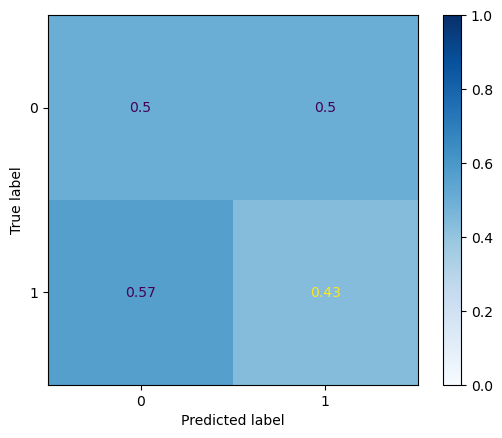

ROC AUC:  0.46698113207547176

3


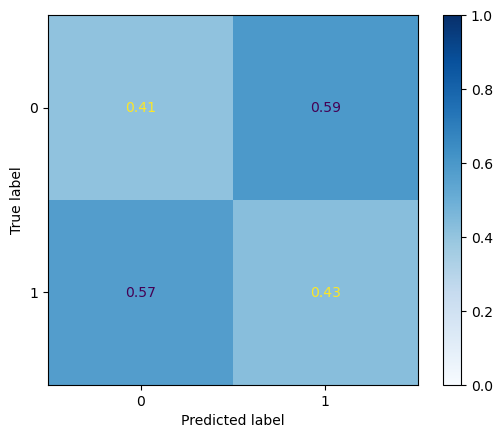

ROC AUC:  0.4188311688311688

5


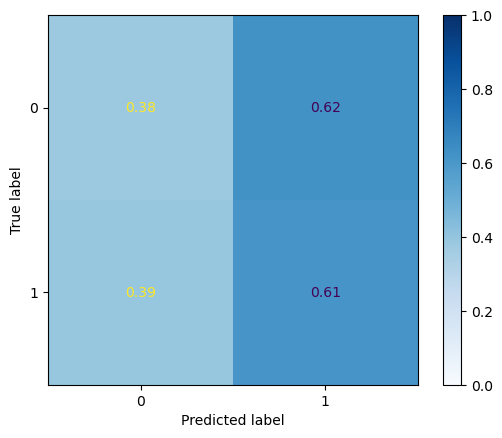

ROC AUC:  0.4927536231884058


WEAT
1


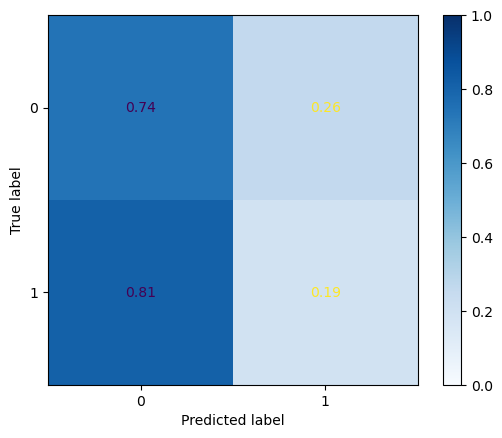

ROC AUC:  0.4653073645769933

3


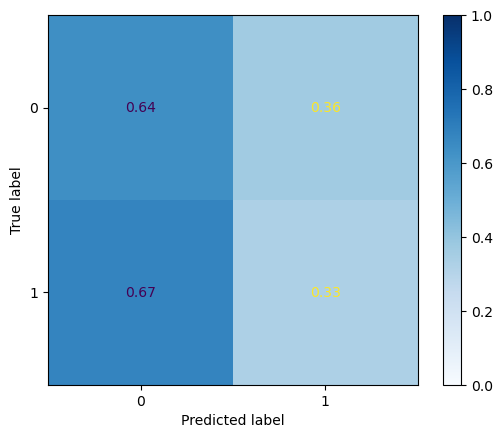

ROC AUC:  0.4814471243042671

5


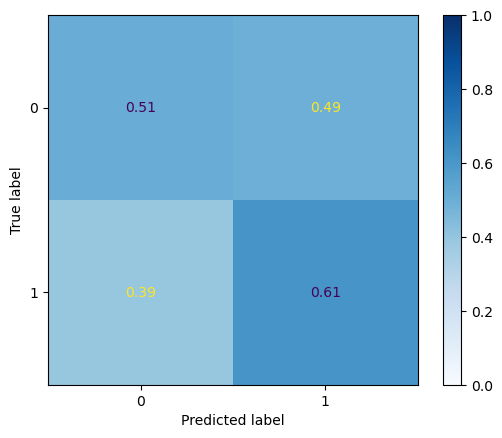

ROC AUC:  0.5579710144927537


gWEAT
1


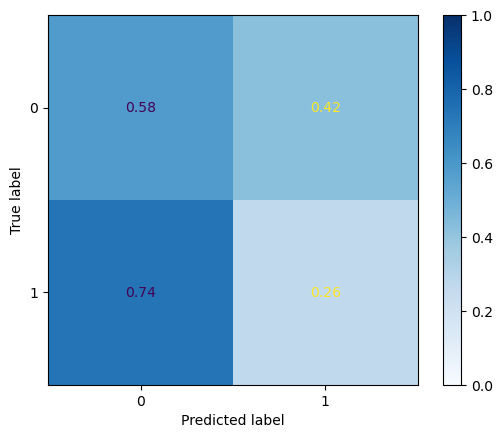

ROC AUC:  0.42239805234327443

3


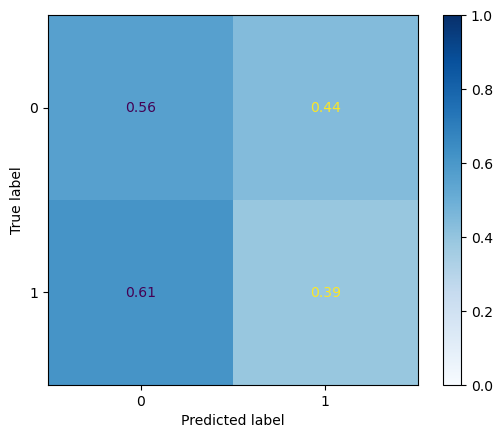

ROC AUC:  0.47418058132343843

5


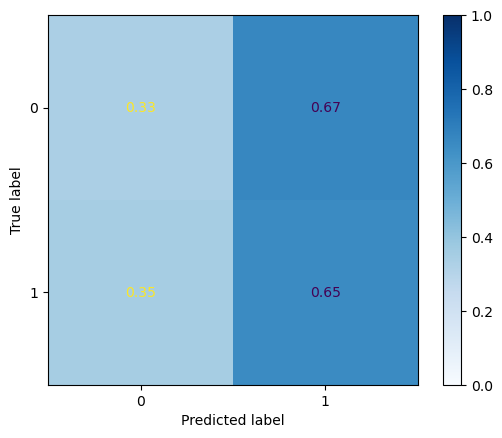

ROC AUC:  0.4927536231884059


DirectBias
1


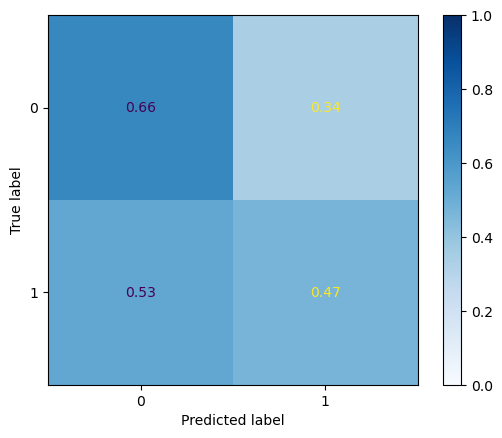

ROC AUC:  0.5664942178940963

3


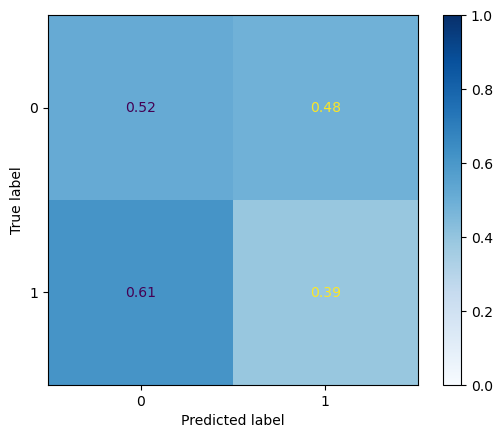

ROC AUC:  0.4514533085961657

5


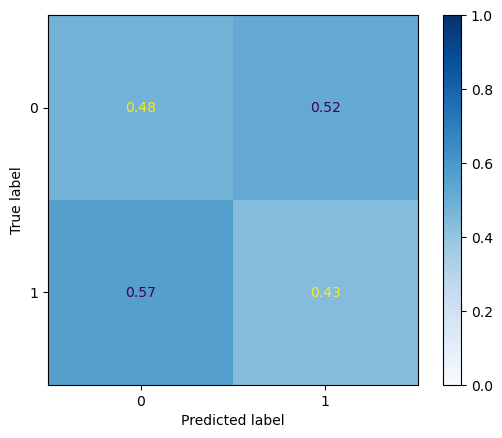

ROC AUC:  0.4565217391304348


MAC
1


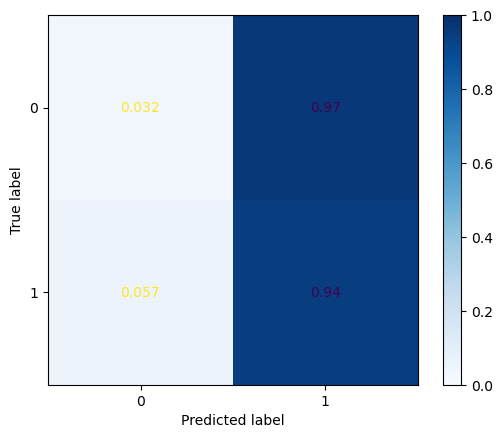

ROC AUC:  0.4878271454656117

3


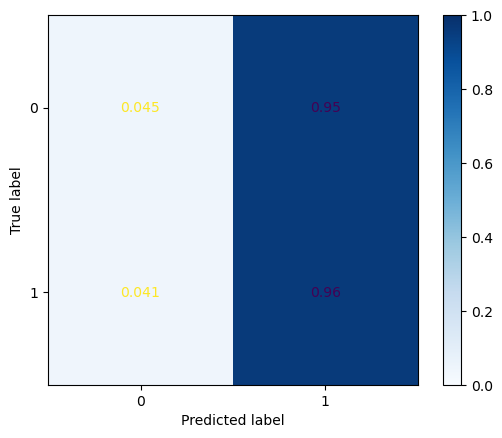

ROC AUC:  0.5023191094619666

5


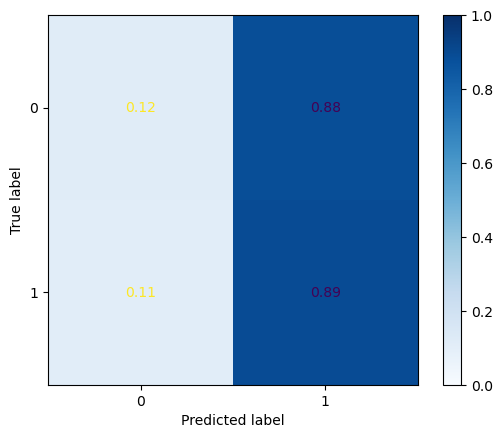

ROC AUC:  0.5036231884057971




In [693]:
for score in cosine_scores.keys():
    print(score)
    for k in debias_ks:
        print(k)
        cm = confusion_matrix(bias_decreased['extrinsic'][k],bias_decreased[score][k], normalize='true')
        cm_display = ConfusionMatrixDisplay(cm).plot()
        cm_display.ax_.get_images()[0].set_clim(0, 1)
        cm_display.ax_.get_images()[0].set_cmap(plt.cm.Blues)
        plt.show()
        print("ROC AUC: ", roc_auc_score(bias_decreased['extrinsic'][k],bias_decreased[score][k]))
        #fpr, tpr, _ = roc_curve(bias_decreased['extrinsic'][k],bias_decreased[score][k])
        #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        print()
    print()

In [511]:
decrease_agree = {score: {k: [] for k in debias_ks} for score in cosine_scores}
for score in cosine_scores:
    exp_idx = 0
    for model in embedder[:-10]:
        low_recall = False
        for idx in range(exp_idx, exp_idx+len(debias_ks)):
            if results[idx]['recall'] < 0.3:
                low_recall = True
        if low_recall:
            print("skip ", model, "because of low recall")
            exp_idx += len(debias_ks)+1
            continue
        default_scores_ex = results[exp_idx]['extrinsic'] # one per split
        default_scores_cos = results[exp_idx][score] # one per split
        exp_idx += 1

        for k in debias_ks:
            for i, fold in enumerate(results[exp_idx]['extrinsic']):
                extrinsic_decrease = fold < default_scores_ex[i]
                cosine_decrease = results[exp_idx][score][i] < default_scores_cos[i]
                decrease_agree[score][k].append(extrinsic_decrease == cosine_decrease)
            exp_idx += 1

print("how often scores agree with the extrinsic biases regarding the reduction of biases after debiasing:")
for score in cosine_scores:
    for k in debias_ks:
        print(score, k, np.sum(decrease_agree[score][k])/len(decrease_agree[score][k]))

how often scores agree with the extrinsic biases regarding the reduction of biases after debiasing:
SAME 1 0.4166666666666667
SAME 3 0.55
SAME 5 0.7
SAME 7 0.6
SAME 9 0.6
WEAT 1 0.7833333333333333
WEAT 3 0.5833333333333334
WEAT 5 0.7833333333333333
WEAT 7 0.7
WEAT 9 0.5666666666666667
gWEAT 1 0.7
gWEAT 3 0.6666666666666666
gWEAT 5 0.7666666666666667
gWEAT 7 0.7
gWEAT 9 0.5666666666666667
DirectBias 1 0.4
DirectBias 3 0.5
DirectBias 5 0.4666666666666667
DirectBias 7 0.3333333333333333
DirectBias 9 0.45
MAC 1 0.16666666666666666
MAC 3 0.6833333333333333
MAC 5 0.55
MAC 7 0.5833333333333334
MAC 9 0.43333333333333335
